### Install required software package


In [11]:
!pip3 -q install pynrrd gitpython quantities --user
!pip3 -q install git+https://github.com/christian-oreilly/nat.git --upgrade --force-reinstall --user

### Update literature annotation corpus

In [12]:
from git import Repo
import os

git_url = "https://github.com/christian-oreilly/corpus-thalamus.git"
repo_dir = os.path.join(os.getcwd(), "neurocuratorDB")
if not os.path.isdir(repo_dir):
    Repo.clone_from(git_url, repo_dir)
else:
    Repo(repo_dir).remotes.origin.pull()

### Import required libraries and packages

In [13]:
import matplotlib.pyplot as plt
import collections
import numpy as np
import quantities as pq
from nat.modelingParameter import getParameterTypeNameFromID
from nat.annotationSearch import ParameterGetter, ParameterSearch, ConditionAtom

### List annotated neuronal densities


In [14]:
searcher = ParameterSearch(pathDB="neurocuratorDB")
searcher.setSearchConditions(ConditionAtom("Parameter name", "neuron_density"))
searcher.expandRequiredTags = True
searcher.onlyCentralTendancy = True
resultDF = searcher.search()
resultDF["Species"] = [tag[0].name for tag in resultDF["Species"]]
resultDF["Values"] = [param.valuesText() for param in resultDF["obj_parameter"]]
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
0,Thalamic reticular nucleus cell - GABAergic,Thalamic reticular nucleus,"[142.9, 178.5, 185.1, 215.8] +/- [17.3, 26.4, ...",mm^-2,Wistar Rat
1,Thalamus relay cell,Ventral posteromedial nucleus,304.3 +/- 16.6 (n=5),mm^-2,Wistar Rat
2,Thalamic reticular nucleus cell,thalamic reticular nucleus,700,1/mm^2,Rat
3,Thalamus relay cell,Lateral geniculate body,246.8 +/- 38.9 (n=5),mm^-2,Wistar Rat
4,Thalamus relay cell,Ventral posterolateral nucleus,150.3 +/- 17.5 (n=5),mm^-2,Wistar Rat
5,Thalamus interneuron small,Ventral posterolateral nucleus,5.9 +/- 1.1 (n=5),mm^-2,Wistar Rat
6,Thalamus interneuron small,Lateral geniculate body,48.4 +/- 12.1 (n=5),mm^-2,Wistar Rat
7,Thalamus interneuron small,Ventral posteromedial nucleus,13.3 +/- 0.6 (n=5),mm^-2,Wistar Rat
8,Thalamic reticular nucleus cell - non-GABAergic,Thalamic reticular nucleus,"[19.5, 45.3, 44.6, 48.8] +/- [11.8, 9.0, 12.6,...",mm^-2,Wistar Rat
9,Thalamus relay cell,Ventral posterior nucleus,"[0.000278146, 0.000170264, 8.88744e-05, 5.1258...",um^-3,Rat


### Rescale to mm⁻³ unit (applying 2D to 3D transformation with the appropriate slice thickness whenever appropriate)

In [15]:
paramGetter = ParameterGetter(pathDB="neurocuratorDB")

values = []
units  = []

def rescale2DStereo(paramID, thicknessValue=1.0, thicknessUnit="um", desiredUnit="mm^-3"):
    density = paramGetter.getParam(paramID)
    thickness = pq.Quantity(thicknessValue, thicknessUnit)
    return (density/thickness).rescale(desiredUnit)

for param, annot, (index, row) in zip(resultDF["obj_parameter"], 
                                      resultDF["obj_annotation"], 
                                      resultDF.iterrows()):
    try:
        param = param.rescale("mm^-3")
    except ValueError:
        thicknessInstanceId = [param.instanceId for param in annot.experimentProperties 
                                if getParameterTypeNameFromID(param.paramTypeId) == "slice_thickness"]

        if len(thicknessInstanceId) == 1:
            thicknessParameter = paramGetter.getParam(thicknessInstanceId[0])
            if len(thicknessParameter.values) == 1:
                param = rescale2DStereo(param.id, thicknessValue=thicknessParameter.values[0], 
                                        thicknessUnit=thicknessParameter.unit, 
                                        desiredUnit="mm^-3")
    units.append(param.unit)
    values.append(param.valuesText())
    resultDF.loc[index, "obj_parameter"] = param   
    
resultDF["Values"] = values
resultDF["Unit"]   = units
    
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
0,Thalamic reticular nucleus cell - GABAergic,Thalamic reticular nucleus,[ 142900. 178500. 185100. 215800.] +/- [ 17...,1/mm**3,Wistar Rat
1,Thalamus relay cell,Ventral posteromedial nucleus,304300.0 +/- 16600.0 (n=5),1/mm**3,Wistar Rat
2,Thalamic reticular nucleus cell,thalamic reticular nucleus,700,1/mm^2,Rat
3,Thalamus relay cell,Lateral geniculate body,246800.0 +/- 38900.0 (n=5),1/mm**3,Wistar Rat
4,Thalamus relay cell,Ventral posterolateral nucleus,150300.0 +/- 17500.0 (n=5),1/mm**3,Wistar Rat
5,Thalamus interneuron small,Ventral posterolateral nucleus,5900.0 +/- 1100.0 (n=5),1/mm**3,Wistar Rat
6,Thalamus interneuron small,Lateral geniculate body,48400.0 +/- 12100.0 (n=5),1/mm**3,Wistar Rat
7,Thalamus interneuron small,Ventral posteromedial nucleus,13300.0 +/- 600.0 (n=5),1/mm**3,Wistar Rat
8,Thalamic reticular nucleus cell - non-GABAergic,Thalamic reticular nucleus,[ 19500. 45300. 44600. 48800.] +/- [ 11800....,1/mm**3,Wistar Rat
9,Thalamus relay cell,Ventral posterior nucleus,[ 278146. 170264. 88874.4 51258.8 501...,1/mm**3,Rat


### Keep only the annotations that could successfully be rescaled to a common unit (mm⁻³)

In [16]:
resultDF = resultDF[resultDF["Unit"] == "1/mm**3"]
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]

,Cell,Regional part of brain,Values,Unit,Species
0,Thalamic reticular nucleus cell - GABAergic,Thalamic reticular nucleus,[ 142900. 178500. 185100. 215800.] +/- [ 17...,1/mm**3,Wistar Rat
1,Thalamus relay cell,Ventral posteromedial nucleus,304300.0 +/- 16600.0 (n=5),1/mm**3,Wistar Rat
3,Thalamus relay cell,Lateral geniculate body,246800.0 +/- 38900.0 (n=5),1/mm**3,Wistar Rat
4,Thalamus relay cell,Ventral posterolateral nucleus,150300.0 +/- 17500.0 (n=5),1/mm**3,Wistar Rat
5,Thalamus interneuron small,Ventral posterolateral nucleus,5900.0 +/- 1100.0 (n=5),1/mm**3,Wistar Rat
6,Thalamus interneuron small,Lateral geniculate body,48400.0 +/- 12100.0 (n=5),1/mm**3,Wistar Rat
7,Thalamus interneuron small,Ventral posteromedial nucleus,13300.0 +/- 600.0 (n=5),1/mm**3,Wistar Rat
8,Thalamic reticular nucleus cell - non-GABAergic,Thalamic reticular nucleus,[ 19500. 45300. 44600. 48800.] +/- [ 11800....,1/mm**3,Wistar Rat
9,Thalamus relay cell,Ventral posterior nucleus,[ 278146. 170264. 88874.4 51258.8 501...,1/mm**3,Rat


### Three of the annotations are actually "numerical traces" which can be displayed...

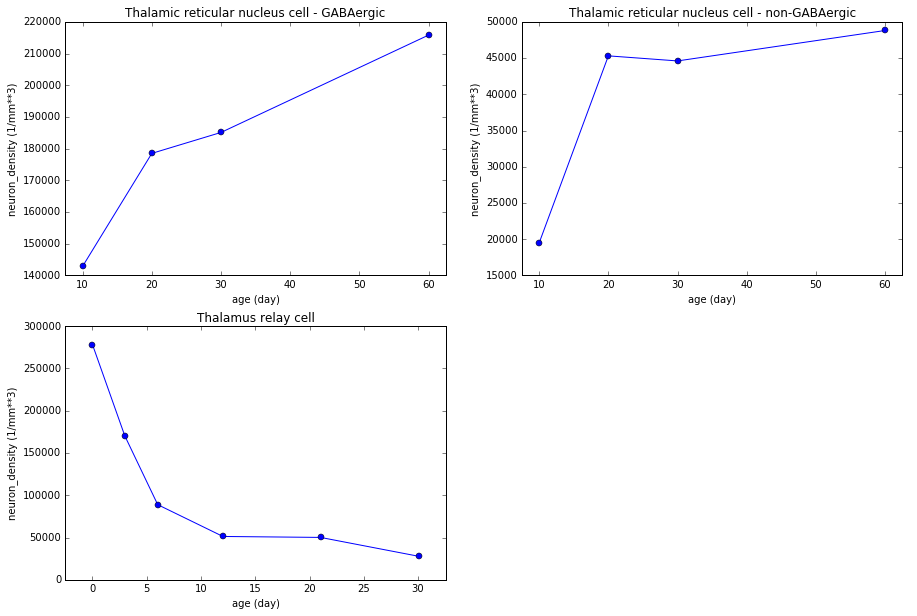

In [24]:
%matplotlib inline

def getFigTrace(param, title="", xlim=None, context=None, index=0):
    if context is None:
        fig, axes = plt.subplots()
    else:
        fig, axarr = context
        if isinstance(axarr, collections.Iterable):
            axes = axarr[index]
        else:
            axes = axarr
        
    axes.plot(param.indepValues[0], param.means, '-o')
    if not xlim is None:
        axes.set_xlim(xlim)
    else:
        axes.set_xlim([min(param.indepValues[0]) -2.5, max(param.indepValues[0])+2.5])
        
    axes.set_ylabel(param.name + " (" + param.unit + ")")
    axes.set_xlabel(param.indepNames[0] + " (" + param.indepUnits[0] + ")")
    axes.set_title(title)
    return fig    

paramTraces = resultDF[resultDF["Result type"] == "numericalTrace"]["obj_parameter"].values
cellTypes   = resultDF[resultDF["Result type"] == "numericalTrace"]["Cell"].values

context = plt.subplots(2, 2, figsize=(15, 10))
for no, (paramTrace, cellType) in enumerate(zip(paramTraces, cellTypes)):
    fig = getFigTrace(paramTrace, title=cellType, context=context, index=(int(no/2), no%2))
context[1][1, 1].axis('off');

### As value, we might want to take the value interpolated at P14... Two of these curves have points specified as mean +/- sem (N=sample_size) from which we only consider the mean values

In [ ]:
finalValues = np.zeros((len(resultDF["Result type"])))
for ind, (paramTrace, resType) in enumerate(zip(resultDF["obj_parameter"], resultDF["Result type"])):
    if resType == "numericalTrace":
        val = paramTrace.getInterp1dValues(14, statsToReturn=["mean"])
        if isinstance(val, list):
            val = val[0]
        finalValues[ind] = float(val)    
        print("Interpolated value:", finalValues[ind])


### The other parameters are also specified as mean +/- std (N=sample_size) from which we only consider the mean value

In [ ]:
for ind, (param, resType) in enumerate(zip(resultDF["obj_parameter"], resultDF["Result type"])):
    if resType != "numericalTrace":
        finalValues[ind] = np.mean(param.means)

resultDF["Values"] = finalValues
resultDF[["Cell", "Regional part of brain", "Values", "Unit", "Species"]]